In [1]:
### Sections labelled according to breakdown of marks
### ie. II.C.x is point x in the breakdown of marks

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.cluster import KMeans

# import iris dataset
iris = pd.read_csv("iris.data", header = None)

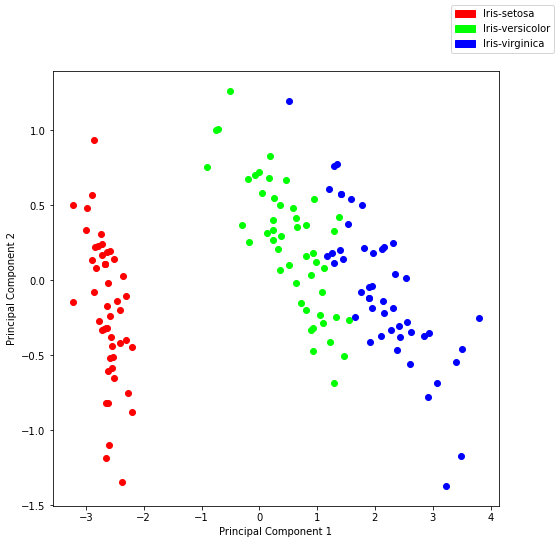

In [2]:
### II.B

def PCA(A) :
    A = A - np.mean(A, axis = 0)        # Subtract mean of each column from each value in that column
    C = np.cov(A, rowvar=False)         # Calculate covariance matrix of A
    eigval, eigvec = np.linalg.eig(C)   # Calculate eigenvectors of the covariance matrix
    X = np.matmul(A, eigvec[:,:2])      # Multiply mean 0 dataframe by matrix of 2 largest principal components
    return pd.DataFrame(X)


#       Plot dataset

df = iris.iloc[:,:4]

Classes = pd.DataFrame(iris.iloc[:,4]).set_axis(['Class'], axis = 1)
df = PCA(df)
# principal components DataFrame
pc_df = pd.concat((df, pd.DataFrame(Classes)), axis = 1)

fig, ax = plt.subplots(figsize=(8,8))
# iris.data comes organised in class order, so can use hard-coded values
ax.scatter(pc_df.iloc[:49,0], pc_df.iloc[:49,1], c='#FF0000')
ax.scatter(pc_df.iloc[50:99,0], pc_df.iloc[50:99,1], c='#00FF00')
ax.scatter(pc_df.iloc[100:149,0], pc_df.iloc[100:149,1], c='#0000FF')

# Legend
red = mpatches.Patch(color='#FF0000', label='Iris-setosa')
green = mpatches.Patch(color='#00FF00', label='Iris-versicolor')
blue = mpatches.Patch(color='#0000FF', label='Iris-virginica')
fig.legend(handles=[red, green, blue], loc=1)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

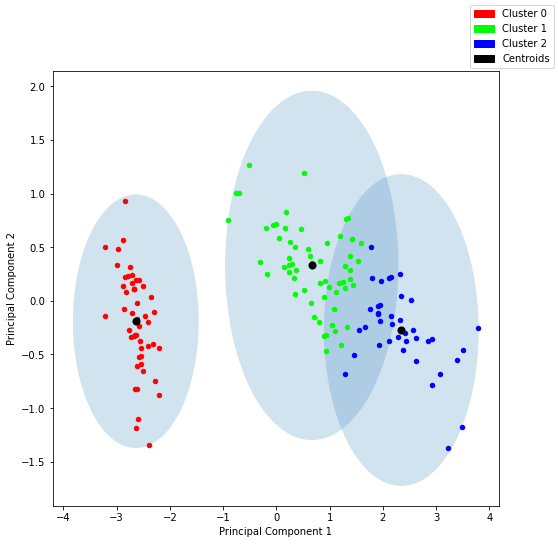

In [39]:
###	II.C.1,2

from scipy.spatial.distance import cdist

#		Apply K-Means for to get initial centroids before applying EM

k = KMeans(n_clusters = 3)
# DataFrame of clusters
zi = pd.DataFrame(k.fit_predict(df)).set_axis(['Cluster'], axis = 1)
# clusters DataFrame
cl_df = pd.concat((df, zi), axis = 1)


fig, ax = plt.subplots(figsize=(8,8))
# Add data points
ax.scatter(cl_df[cl_df.Cluster == 0][0], cl_df[cl_df.Cluster == 0][1], c='#FF0000', s=20)
ax.scatter(cl_df[cl_df.Cluster == 1][0], cl_df[cl_df.Cluster == 1][1], c='#00FF00', s=20)
ax.scatter(cl_df[cl_df.Cluster == 2][0], cl_df[cl_df.Cluster == 2][1], c='#0000FF', s=20)

ax.scatter(k.cluster_centers_[:,0], k.cluster_centers_[:,1], c='#000000', s=50)

# Calculate radius of clusters (distance of furthest point in cluster)
r = [cdist(np.full((df[cl_df.Cluster == 0].shape[0],2), k.cluster_centers_[0,:]),df[cl_df.Cluster == 0]).max(),
 	cdist(np.full((df[cl_df.Cluster == 1].shape[0],2), k.cluster_centers_[1,:]),df[cl_df.Cluster == 1]).max(),
	cdist(np.full((df[cl_df.Cluster == 2].shape[0],2), k.cluster_centers_[2,:]),df[cl_df.Cluster == 2]).max()]

# Plot circles around clusters
ax.add_patch(mpatches.Circle(k.cluster_centers_[0,:], r[0], alpha = 0.2, zorder = 0))
ax.add_patch(mpatches.Circle(k.cluster_centers_[1,:], r[1], alpha = 0.2, zorder = 0))
ax.add_patch(mpatches.Circle(k.cluster_centers_[2,:], r[2], alpha = 0.2, zorder = 0))

# Legend
red = mpatches.Patch(color='#FF0000', label='Cluster 0')
green = mpatches.Patch(color='#00FF00', label='Cluster 1')
blue = mpatches.Patch(color='#0000FF', label='Cluster 2')
black = mpatches.Patch(color='#000000', label='Centroids')
fig.legend(handles=[red, green, blue, black], loc=1)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [57]:
### II.C.3

from scipy.stats import multivariate_normal

# Convert K-Means clusters to responsibilities for EM
res = []
for i in range(150):
    if cl_df.values[i][2] == 0:
        res.append([1,0,0])
    elif cl_df.values[i][2] == 1:
        res.append([0,1,0])
    else:
        res.append([0,0,1])

# DataFrame with responsibilities
dfr = pd.concat((cl_df, pd.DataFrame(res)), axis = 1).set_axis(['PC1','PC2','Cluster','0','1','2'], axis = 1)

# means are cluster centers predicted by K-Means
mu = np.array(k.cluster_centers_)
# covariance matrices for each cluster predicted by K-Means
sigma = np.array([np.cov(np.transpose(df[cl_df.Cluster == 0])),np.cov(np.transpose(df[cl_df.Cluster == 1])),np.cov(np.transpose(df[cl_df.Cluster == 2]))])

### II.C.4

def E(A, mu, sigma):
    ric = []            # responsibilities for x i for cluster c

    # Probabilities of zi=c for each c
    P0 = len(df[A.Cluster == 0]) / 150      
    P1 = len(df[A.Cluster == 1]) / 150
    P2 = len(df[A.Cluster == 2]) / 150
    # calculate new responsibilities
    for c in range(3):
        xr = []         # responsibilites for all x for cluster c

        # Probabilities of zi=c for current c
        Pc = len(df[A.Cluster == c]) / 150
        for x in df.values:
            # Probabilities xi|zi=c 
            PDF0 = multivariate_normal.pdf(x, mean=mu[0,:], cov=sigma[c])
            PDF1 = multivariate_normal.pdf(x, mean=mu[1,:], cov=sigma[c])
            PDF2 = multivariate_normal.pdf(x, mean=mu[2,:], cov=sigma[c])
            PDFc = multivariate_normal.pdf(x, mean=mu[c,:], cov=sigma[c])
            # Calculate the responsibility c has over x
            r = (PDFc * Pc) / ((PDF0 * P0) + (PDF1 * P1) + (PDF2 * P2))
            xr.append(r)
        ric.append(xr)
    ric = np.transpose(ric)
    c = np.empty(150)
    # calculate new cluster for each data point
    for i in range(150):
        m = max(ric[i])
        c[i] = np.where(ric[i] == m)[0][0]
    A = pd.concat((df, pd.DataFrame(c), pd.DataFrame(ric)), axis = 1).set_axis(['PC1','PC2','Cluster','0','1','2'], axis = 1)
    return(M(A,mu))

def M(A, old_mu):

    pi = np.empty(3)
    mu = np.empty((3,2))
    sigma = np.empty((3,2,2))
    for i in range(3):
        # Calculate new cluster probabilities using (18)
        pi[i] = np.sum( np.array(A[str(i)])) / 150

        # Calculate new cluster centroids using (19)
        rx = np.array(df)*np.array(A[str(i)])[:,np.newaxis]
        mu[i] = np.divide(    np.sum(rx, axis=0) , np.sum( np.array(A[str(i)]))   )

        # Calculate new cluster covariances using (20)
        sigma[i] = np.array(np.matmul(   (np.transpose((np.array(df) - mu[i]) * np.array(A[str(i)])[:,np.newaxis])), (np.array(df) - mu[i]) )   )   / np.sum(np.array(A[str(i)])       )

    conv = np.sum(abs(mu-old_mu))
    # Convergence criteria - average change of 0.001 per coordinate
    if conv < 0.006:
        return(A,mu,sigma,pi)
    
    return(E(A, mu, sigma))
B = E(dfr,mu,sigma)

In [54]:
###	II.C.5
print("pi =\n",B[3],"\n")
print("mu =\n",B[1],"\n")
print("sigma =\n",B[2],"\n")

pi =
 [0.33333333 0.32588501 0.34165829] 

mu =
 [[-2.64084076 -0.19051995]
 [ 0.53107416  0.22481628]
 [ 2.03465172 -0.01537961]] 

sigma =
 [[[ 0.04777048 -0.05590782]
  [-0.05590782  0.21472356]]

 [[ 0.3680002  -0.21559783]
  [-0.21559783  0.1859681 ]]

 [[ 0.57558114 -0.29740007]
  [-0.29740007  0.23321222]]] 



In [47]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [55]:
### II.C.6

# Note : assumes that the clusters from left to right are 0 (red), 1 (green), and 2 (blue)
# This is due to the randomness of the order of the K-Means algorithm in assigning clusters

nKM = 150
for i in range(50):
	if cl_df['Cluster'][i] != 0:
		nKM = nKM - 1
	if cl_df['Cluster'][i+50] != 1:
		nKM = nKM - 1
	if cl_df['Cluster'][i+100] != 2:
		nKM = nKM - 1
print("Accuracy of K-Means =\n", nKM/1.5,"%")

nEM = 150
for i in range(50):
	if B[0]['Cluster'][i] != 0:
		nEM = nEM - 1
	if B[0]['Cluster'][i+50] != 1:
		nEM = nEM - 1
	if B[0]['Cluster'][i+100] != 2:
		nEM = nEM - 1
print("Accuracy of EM =\n", nEM/1.5,"%")

Accuracy of K-Means =
 88.66666666666667 %
Accuracy of EM =
 97.33333333333333 %


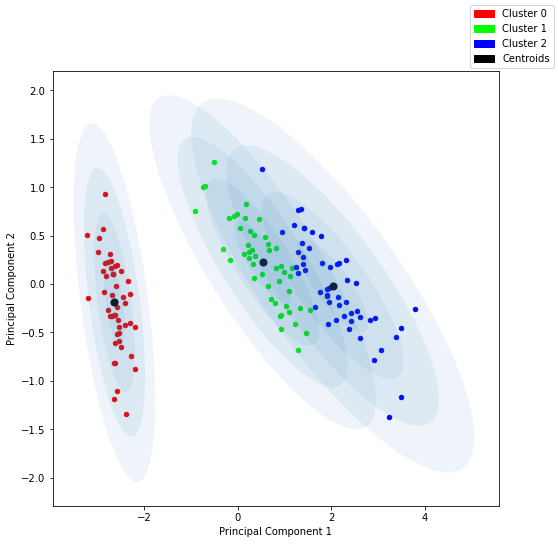

In [58]:
###	II.C.7

fig, ax = plt.subplots(figsize=(8,8))
# Add data points
ax.scatter(B[0][B[0].Cluster == 0]['PC1'], B[0][B[0].Cluster == 0]['PC2'], c='#FF0000', s=20)
ax.scatter(B[0][B[0].Cluster == 1]['PC1'], B[0][B[0].Cluster == 1]['PC2'], c='#00FF00', s=20)
ax.scatter(B[0][B[0].Cluster == 2]['PC1'], B[0][B[0].Cluster == 2]['PC2'], c='#0000FF', s=20)

# Plot cluster means
ax.scatter(B[1][:,0], B[1][:,1], c='#000000', s=50)

# Plot ellipses
draw_ellipse(B[1][0], B[2][0], alpha = 0.075)
draw_ellipse(B[1][1], B[2][1], alpha = 0.075)
draw_ellipse(B[1][2], B[2][2], alpha = 0.075)

# Legend
red = mpatches.Patch(color='#FF0000', label='Cluster 0')
green = mpatches.Patch(color='#00FF00', label='Cluster 1')
blue = mpatches.Patch(color='#0000FF', label='Cluster 2')
black = mpatches.Patch(color='#000000', label='Centroids')
fig.legend(handles=[red, green, blue, black], loc=1)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()